In [1]:
import sys
sys.path.append('../../..')
#sys.path.append( '/home/cactuskid13/miniconda3/pkgs/')
print(sys.path)

['/scratch/dmoi/projects/HogProf/pyprofiler/notebooks/eccb', '/scratch/dmoi/condaenvs/ML2/lib/python39.zip', '/scratch/dmoi/condaenvs/ML2/lib/python3.9', '/scratch/dmoi/condaenvs/ML2/lib/python3.9/lib-dynload', '', '/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages', '/scratch/dmoi/software/pyham', '/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/IPython/extensions', '/users/dmoi/.ipython', '../../..']


In [2]:
import torch

In [3]:
from pyprofiler.utils import hashutils
import ete3
import random
from pyprofiler.utils import config_utils
import pyprofiler.utils.goatools_utils as goa
import pyprofiler.utils.hashutils as hashutils
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pyprofiler.profiler as profiler
import pandas as pd
import itertools
import redis
import dask
import warnings

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import scipy
from dask import dataframe as dd
import pickle
from bloom_filter2 import BloomFilter
from sklearn.model_selection import train_test_split


/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if line is '\n':


{'dir': {'datadir': '/scratch/dmoi/datasets/birds/', 'omadir': '/scratch/dmoi/datasets/birds/'}, 'orthoxmltar': '', 'email': 'dmoi@unil.ch'}


In [4]:
#lets load a compiled db containing the OMA root HOGs into a profiler oject 
p = profiler.Profiler(lshforestpath = '/scratch/dmoi/datasets/all/newlshforest.pkl' , hashes_h5='/scratch/dmoi/datasets/all/hashes.h5' , mat_path= None, oma = '/scratch/dmoi/datasets/OMA/apr2021/OmaServer.h5', tar= None , nsamples = 256 , mastertree = '/scratch/dmoi/datasets/birds/all_test_master_tree.pkl')

loading lsh
indexing lsh


/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/tables/leaf.py:367: PerformanceWarning: The Leaf ``/Protein/_i_Entries/OmaHOG/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  warnings.warn("""\


3508
DONE


In [5]:
#map ids to OMA HOGs
def grabHog(ID, verbose = True):
    try:
        entry = p.db_obj.entry_by_entry_nr(p.db_obj.id_resolver.resolve(ID))
        return entry[4].decode() , entry
    except:
        return np.nan,np.nan


In [8]:
#filtering down the humap dataset
humap = '/scratch/dmoi/datasets/humap_PPI/humap2_ppis_ACC_20200821.pairsWprob'
calc_humap = False
if calc_humap == True:
    #load humap data
    humap_df = pd.read_table(humap, header = None)
    print(humap_df)
    print(len(humap_df))
    humap_df = humap_df[humap_df[2] > .75 ]
    mapper = set( list(humap_df[1]) + list(humap_df[0]) )
    mapper = { protid: grabHog(protid) for protid in mapper }
    humap_df['hog1'] = humap_df[1].map(mapper)
    humap_df['hog2'] = humap_df[0].map(mapper)
    humap_df['hogid_1'] = humap_df['hog1'].map(lambda x:x[0])
    humap_df['hogid_2'] = humap_df['hog2'].map(lambda x:x[0])
    humap_df = humap_df.dropna()
    humap_df['fam1'] = humap_df['hog1'].map( lambda x :   p.hogid2fam(x[1]) )
    humap_df['fam2'] = humap_df['hog2'].map( lambda x :   p.hogid2fam(x[1]) ) 
    humap_df = humap_df.dropna()
    humap_df.fam1 = humap_df.fam1.map(int)
    humap_df.fam2 = humap_df.fam2.map(int)
    print(len(humap_df))
    humap_df.to_csv(humap+'hogmapped.csv')
else:
    humap_df = pd.read_csv(humap+'hogmapped.csv')

                  0                1             2
0            P46926           Q8TDQ7  1.000000e+00
1            P43631           Q14954  1.000000e+00
2            P43631           Q14953  1.000000e+00
3            P43631           P43629  1.000000e+00
4         100287045           Q86YD7  1.000000e+00
...             ...              ...           ...
17526306     Q9H6Z4           Q7L1Q6  3.000000e-14
17526307     Q9Y265           P54578  3.000000e-14
17526308     P16152           P04406  3.000000e-14
17526309     Q96AE4           P78417  3.000000e-14
17526310     P20042  ENSG00000180574  3.000000e-14

[17526311 rows x 3 columns]
17526311


/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/tables/leaf.py:367: PerformanceWarning: The Leaf ``/_i_XRef/XRefId/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  warnings.warn("""\


8360


In [9]:
print(len(humap_df))

8360


In [7]:
humap_pairs = humap_df

In [8]:
#calculating the profile vectors for each HOG in the Humap dataset
profiles = {}
calc_hogs_humap = False
if calc_hogs_humap == True:
    allhogs = set([])
    allhogs = allhogs.union( set(humap_df.fam1.unique() ) )
    allhogs = allhogs.union( set(humap_df.fam2.unique() ) )
    print(len(allhogs))
    for fam in allhogs:
        print(fam)
        try:
            prof = p.return_profile_OTF(fam)
        except:
            print('err', fam)
        print(prof)
        profiles.update(prof)

In [9]:
save_Hogs_humap = False
if save_Hogs_humap == True:
    with open(humap + 'gold_standard_profiles.pkl' , 'wb') as profiles_out:
        profiles_out.write(pickle.dumps(profiles))

In [10]:
with open(humap + 'gold_standard_profiles.pkl' , 'rb') as profiles_out:
    humap_profiles = pickle.loads(profiles_out.read())

In [11]:
humap_df = pd.DataFrame.from_dict(humap_profiles , orient = 'index')
print(humap_df.head())

                                                      mat  \
524288  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
516097  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
516099  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
786438  [[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0,...   
573452  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                     tree  
524288  (((\n--7757)), ((\n--7764)), ((\n--9597)), ((\...  
516097  (((\n--9597)), ((\n--9598)), ((\n--9606)), ((\...  
516099  (((\n--9597)), ((\n--9598)), ((\n--9606)), ((\...  
786438  (((\n--868595)), ((\n--349161)), ((\n--696281)...  
573452  (((\n--120017)), ((\n--237631)), ((\n--1230383...  


In [12]:
#################begin building the string dataset ###################################

In [13]:
filter_coglinks = False
#filtering down the COGlinks using cutoffs for global score and text mining
if filter_coglinks == True:
    from collections import Counter
    coglink_df = dd.read_csv('/scratch/dmoi/datasets/STRING/COG.links.detailed.v11.5.txt', blocksize=25e6 , header = 0, sep = ' ')
    print(coglink_df)
    print(coglink_df.columns)
    dropcols = [ 'cooccurence', 'combined_score' ]
    coglink_df = coglink_df.drop(columns = dropcols)
    coglink_df['score'] = coglink_df.coexpression + coglink_df.experimental +coglink_df.database+ coglink_df.textmining
    #these cutoffs ere found below using jaccard and AUC
    coglink_df= coglink_df[coglink_df.score>1000]
    coglink_df= coglink_df[coglink_df.textmining>500]

    coglink_df = coglink_df.compute()
    
    coglink_count = Counter(list(coglink_df.group1)+list(coglink_df.group2))
    coglink_df['count1']= coglink_df.group1.map(coglink_count)
    coglink_df['count2']= coglink_df.group2.map(coglink_count)
    #filter input set
    #coglink_df = coglink_df[coglink_df.count1 > 50 ]
    #coglink_df = coglink_df[coglink_df.count2 > 50 ]
    
    print(coglink_df.head() , len(coglink_df))

In [14]:
#map the interacting cogs to the proteins
compute_grabcogs = False
if compute_grabcogs == True:
    grabcogs = set( list(coglink_df.group1.unique()) + list(coglink_df.group2.unique()) )
    grabcogs= list(grabcogs)
    COGmapings_df = dd.read_csv('/scratch/dmoi/datasets/STRING/COG.mappings.v11.5.txt', blocksize=25e6 , header = 0, sep = '\t')
    COGmapings_df = COGmapings_df.set_index('orthologous_group')
    COGmapings_df.astype(str)
    COGmapings_df['##protein'].map( lambda x : x.strip() )
    COGmapings_df['species'] = COGmapings_df['##protein'].map( lambda x : x.split('.')[0] )
    COGmapings_df['COG'] = COGmapings_df.index
    COGmapings_df = COGmapings_df.loc[grabcogs]
    COGmapings_df = COGmapings_df.compute()
    print(COGmapings_df.head())

In [15]:
#only take the proteins in our cogs of interest
if compute_grabcogs == True:
    grabprots =list(COGmapings_df['##protein'].unique())
    print(len(grabprots))
    with open('/scratch/dmoi/datasets/STRING/COG.links.detailed.v11.5.txt' + '.grabcogs.txt', 'w') as protsout:
        protsout.write(''.join([ p + '\n' for p in grabcogs ]) )
    with open('/scratch/dmoi/datasets/STRING/COG.mappings.v11.5.txt' + '.grabprots.txt' , 'w') as protsout:
        protsout.write(''.join([ p + '\n' for p in grabprots ]) )
else:
    with open('/scratch/dmoi/datasets/STRING/COG.links.detailed.v11.5.txt' + '.grabcogs.txt', 'r') as protsout:
        grabcogs = [ cog for cog in protsout.readlines()]
    with open('/scratch/dmoi/datasets/STRING/COG.mappings.v11.5.txt' + '.grabprots.txt' , 'r') as protsout:
        grabprots = [ prot for prot in protsout.readlines()]

In [16]:
calc_mappers = False
#use redis to store the mapping of proteins to their cogs
if calc_mappers == True:
    rdb = redis.Redis(host='10.202.12.174', port=6379, db=0)
    count = 0
    for i,r in COGmapings_df.iterrows():
        rdb.set(r['##protein'], i)
        count+=1
        if count < 10:
            print(i+'\n',r)
        if count%1000000==0:
            print(count/len(COGmapings_df))

In [17]:
maphogs = False
if maphogs == True:
    #you need to change this for your own rdb configuration
    #this is used later by the distributed computation
    #mapping each string cog to an oma hog by selecting a member of the cog
    rdb = redis.Redis(host='10.202.12.174', port=6379, db=0)
    hogmap = {}
    for i,prot in enumerate(grabprots):
        if i % 100000 == 0 :
            print(i/len(grabprots))
        cog = rdb.get(prot)
        if cog not in hogmap:
            mapped =  grabHog(prot)
            #retry until something maps
            if mapped[0] != np.nan and type(mapped[0]) == str :
                if len(mapped[0])>1 :
                    hogmap[cog] = mapped
    with open('stringhogmap.pkl' , 'wb')as hogmapout:
        hogmapout.write(pickle.dumps(hogmap))
else:
    with open('stringhogmap.pkl' , 'rb')as hogmapout:
        hogmap = pickle.loads(hogmapout.read())


In [18]:
print(len(hogmap))
for i, key in enumerate(hogmap):
    if i < 10:
        print(key, hogmap[key])

12761
b'COG0022' ('HOG:A0772469', (1134780, 359776777, 338, 36877, b'HOG:A0772469', b'A', 136963, 137976, -1, 0, b'Q9K3H1', 1080465110, 1015, b'6161cbb7b6aed10547b7c95555c1c63a', 60128051, 322, b'', -1, -1))
b'COG1071' ('HOG:A0780700.10b.7b', (3753108, 1179251817, 734, 598427, b'HOG:A0780700.10b.7b', b'A', 2952449, 2954650, -1, 0, b'F4GWD5', 3541508558, 2203, b'0eaa8538e27a234812d4b19c67f1f560', 234217123, 43, b'', -1, -1))
b'COG0508' ('HOG:A0757171.22b.54b.29a', (3288989, 1034223672, 469, 598421, b'HOG:A0757171.22b.54b.29a', b'A', 1363913, 1365319, 1, 0, b'G4R8Y9', 3105960004, 1408, b'3b9ecc15f5881cc16928ba7e6a656fe6', 205095449, 48, b'', -1, -1))
b'COG0462' ('HOG:A0780700', (14151364, 5935651032, 846, 598427, b'HOG:A0780700', b'supercontig_To_g48347', 2246, 4990, -1, 0, b'K0RIS8', 17821104459, 2539, b'8f2ac7bfb36b9ffe82ad5d8dc2410bae', 696068665, 22, b'', -1, -1))
b'COG4886' ('HOG:A0779810.2c.30a.12a.2a', (16107232, 6695185680, 411, 598444, b'HOG:A0779810.2c.30a.12a.2a', b'1', 160094

In [19]:
#add the HOGs to the COGdf
#grab the corresponding profiles
compile_final_cogdf = False
if compile_final_cogdf == True:
    print(len(coglink_df))
    try:
        coglink_df.group1  = coglink_df.group1.map( lambda x : x.encode())
        coglink_df.group2  = coglink_df.group2.map( lambda x : x.encode())
    except:
        pass
    coglink_df['hog1'] = coglink_df.group1.map(hogmap)
    coglink_df['hog2'] = coglink_df.group2.map(hogmap)
    coglink_df=coglink_df.dropna()
    print(len(coglink_df))
    print(coglink_df.head())
    coglink_df['hogid_1'] = coglink_df['hog1'].map(lambda x:x[0])
    coglink_df['hogid_2'] = coglink_df['hog2'].map(lambda x:x[0])
    coglink_df['fam1'] = coglink_df['hog1'].map( lambda x :   p.hogid2fam(x[1]) )
    coglink_df['fam2'] = coglink_df['hog2'].map( lambda x :   p.hogid2fam(x[1]) ) 
    coglink_df.fam1 = coglink_df.fam1.map(int)
    coglink_df.fam2 = coglink_df.fam2.map(int)
    stringHOGs = set(coglink_df.fam1.unique()).union(set(coglink_df.fam2.unique()))
    print(len(stringHOGs))
    print(coglink_df)
    coglink_df.to_csv('STRINGCOGS2OMAHOGS.csv')
else:
    coglink_df = pd.read_csv('STRINGCOGS2OMAHOGS.csv')

In [20]:
stringPairs = coglink_df

In [21]:
#derive explicit profiles for our hogs of interest in string
calc_hogs_string = False
stringprofiles = {}
if calc_hogs_string == True:
    print('profiles to calclulate',len(stringHOGs))
    for i,fam in enumerate(stringHOGs):
        if i % 100 ==0:
            print(i)
        try:
            prof = p.return_profile_OTF(fam)
            stringprofiles.update(prof)
        except:
            print('err',fam)

In [22]:
if calc_hogs_string == True:
    with open('/scratch/dmoi/datasets/STRING/' + 'gold_standard_profiles.pkl' , 'wb') as profiles_out:
        profiles_out.write(pickle.dumps(stringprofiles))

In [23]:
with open('/scratch/dmoi/datasets/STRING/' + 'gold_standard_profiles.pkl' , 'rb' )as profiles_out:
    stringprofiles = pickle.loads(profiles_out.read())

In [24]:
string_df = pd.DataFrame.from_dict(stringprofiles , orient='index')

In [25]:
#make the profiles for this small set of HOGs
for i, key in enumerate(stringprofiles):
    if i < 10:
        print(key,stringprofiles[key])

786432 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f28c4cd991)}
786433 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f28c44260a)}
524294 {'mat': array([[0., 0., 0., ..., 0., 0., 0.]]), 'tree': Tree node '7742' (0x7f28c4131ca)}
786440 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f28c40e958)}
524299 {'mat': array([[0., 0., 0., ..., 0., 0., 0.]]), 'tree': Tree node '7742' (0x7f28c3e0a1c)}
786448 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f28c3daea6)}
786449 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f28c3ad06a)}
786450 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f28c37702e)}
131092 {'mat': array([[0., 0., 0., ..., 0., 0., 0.]]), 'tree': Tree node '1648030' (0x7f28c347bee)}
524309 {'mat': array([[0., 0., 0., ..., 0., 0., 0.]]), 'tree': Tree node '7742' (0x7f28c348f04)}


In [26]:
#now we have profiles for all HUMAP and COG interactions
#String has interactions from each COG in different species.
#We need a way to check for the presence of interaction within a species for a COG
#for this we will create a bloom filter with all the interactions between our cogs

calc_filter = False

In [27]:
if calc_filter == True:
    from dask.distributed import fire_and_forget
    from dask.distributed import Client, Variable , Queue , Lock ,LocalCluster
    from dask_jobqueue import SLURMCluster
    from dask.distributed import  utils_perf
    from dask.distributed import Client, LocalCluster
    import dask
    import redis
    from bloom_filter2 import BloomFilter
    import lzma
    from dask import dataframe as dd
    distributed = True

In [28]:
if calc_filter == True:
    #using distributed computation on a slurm cluster here. This is my particular config. You will need to alter this: https://distributed.dask.org/en/stable/
    if distributed == True:
        NCORE = 4
        print('deploying cluster')
        cluster = SLURMCluster(
            walltime='4:00:00',
            n_workers = NCORE,
            cores=NCORE,
            processes = NCORE,
            interface='ib0',
            memory="120GB",
            env_extra=[
            'source /scratch/dmoi/miniconda/etc/profile.d/conda.sh',
            'conda activate ML2'
            ],
            #scheduler_options={'interface': 'ens2f0' },
            #if gpu node
            scheduler_options={'interface': 'ens3f0' },
            #extra=["--lifetime", "3h55m", "--lifetime-stagger", "4m"]
        )
        print(cluster.job_script())

    else:
        cluster = LocalCluster()
        client = Client(cluster)

In [29]:
if calc_filter == True:
    if distributed == True:
        print(cluster)
        cluster.scale(jobs = 100)
        print(cluster.dashboard_link)
        client = Client(cluster , timeout='450s' , set_as_default=True )

In [30]:
#find which species each of the cogs has an interaction in
if calc_filter == True:
    
    #link_df = dd.read_csv('/scratch/dmoi/datasets/STRING/protein.physical.links.detailed.v11.5.txt', blocksize=100e6 , header = 0, sep = ' ')
    link_df = dd.read_csv('/scratch/dmoi/datasets/STRING/protein.links.full.v11.5.txt',  blocksize=75e6 , header = 0, sep = ' ')
    print(link_df)
    

In [31]:
#compute bloom filters for protein pairs
@dask.delayed
def mapcogs(df ):
    #you need a redis server running on your cluster for this to work. change your ip, port and db number accordingly
    rdb = redis.Redis(host='10.202.12.174', port=6379, db=0)
    if type( df ) == tuple:
        df = df[0]
    protlist1 = list(df.protein1.map(lambda x:str(x).strip()))
    protlist2 = list(df.protein2.map(lambda x:str(x).strip()))
    protlist = list(set(protlist1+protlist2))
    data = rdb.mget(protlist)
    mapper = dict(zip(protlist, data) )
    df['COG1'] = df.protein1.map(mapper)
    df['COG2'] = df.protein2.map(mapper)
    df = df.dropna()
    df['COG1'] = df.COG1.map(lambda x:str(x).replace("b",'').replace("'",'').strip() )
    df['COG2'] = df.COG2.map(lambda x:str(x).replace("b",'').replace("'",'').strip() )
    df['species'] = df.protein1.map(lambda x:x.split('.')[0])
    df['coglinks'] = df.COG1 + '_' + df.COG2 + '_' + df.species
    ret = set(df.coglinks.unique())
    return ret
@dask.delayed
def return_filter(coglinks, verbose = True):
    if type( coglinks ) == tuple:
        coglinks = coglinks[0]
    b=BloomFilter(max_elements=10**8, error_rate=0.001 ,start_fresh = True)
    for p in coglinks:
        b.add( p )
    retlen = len(coglinks)
    return   b , retlen

@dask.delayed
def sumfilter(f1,f2, total ):
    if type( f1 ) == tuple:
        f1 = f1[0]
    if type( f2 ) == tuple:
        f2 = f2[0]
    f3 = f1.__ior__(f2)
    return f3 , total

In [32]:
def treesum(totalfilter):
    print(len(totalfilter))
    while len(totalfilter)>1:
        next_round= []
        for i in range(0,len(totalfilter),2):
            if i+1 < len(totalfilter):
                next_round.append( sumfilter( totalfilter[i][0] , totalfilter[i+1][0] , totalfilter[i][1]+totalfilter[i+1][1]  ) )
        if len(totalfilter) % 2 !=0:
            next_round.append(totalfilter[-1])
        totalfilter = next_round
        print(len(totalfilter))
    return totalfilter

if calc_filter == True:
    b=BloomFilter(max_elements=10**8, error_rate=0.001 ,start_fresh = True)
    partitions  = link_df.to_delayed()
    print('map cogs')
    res1 = [ mapcogs(p) for p in partitions ]
    print('done')
    print('make filters')
    res2 = [ return_filter(p) for p in res1 ]
    finals =[]
    for chunk in range(int(len(res2)/1024)+1):
        print(chunk*1024)
        res3 = res2[chunk*1024:(chunk+1)*1024]
        res4 = treesum(res3)
        res4 = dask.compute(res4)
        print(res4)
        finals.append(res4[0])

    with open('bloomfinal_big.pkl' , 'wb' ) as finalout:
        finalout.write(pickle.dumps(finals))

In [33]:
if calc_filter == True:
    with open('bloomfinal_big.pkl' , 'wb' ) as finalout:
        finalout.write(pickle.dumps(finals))


In [34]:
with open('bloomfinal_big.pkl' , 'rb' ) as finalout:
    resfinal = pickle.loads(finalout.read()) 
print(resfinal)

[[(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 88441700)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 104024529)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 139867517)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 148873261)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 79242584)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 84543441)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 79065634)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 87236883)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 119141778)], [(BloomFilter(ideal_num_elements_n=100000000, erro

In [35]:
#lets see if our filter function works
def check_filters(element,filters):
    for f in filters:
        if element in f[0][0]:
            return True
    return False
import functools
bfilter = functools.partial(check_filters , filters= resfinal)
#should be in there
print(bfilter('COG1756_COG0088_4113'))
#should not be in there...
print(bfilter('crap'))

True
False


In [36]:
#lets make sure all of our string species are mapped to their corresponding OMA equivalent
taxmapper = 'string2oma_specmap.pkl'
calc_taxmapper = False
if calc_taxmapper == True:
     with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        #compare lineages to get the closest
        from ete3 import NCBITaxa
        ncbi = NCBITaxa()
        #map profiler leaves to closest leaf in string
        strings_species = '/scratch/dmoi/datasets/STRING/species.v11.5.txt'
        string_specdata = pd.read_table(strings_species)
        print(string_specdata)
        stringset = set([ str(tax) for tax in list(string_specdata['#taxon_id']) ]) 
        omaset =  set([ spec.name  for spec in p.tree.get_leaves()])
        print('omaset',len(omaset))
        print('stringset',len(stringset))
        shared_leaves = omaset.intersection(stringset)
        missing_leaves = omaset - stringset
        #these are oma leaves not in string...we can map to the closest string species.
        string_missing = stringset - omaset
        omalineages = {tax: set(ncbi.get_lineage(int(tax))) for tax in missing_leaves}
        stringlineages = {tax: set(ncbi.get_lineage(int(tax))) for tax in string_missing}
        string2oma={}
        print('done lineages')
        for i,tax in enumerate(stringlineages):
            #find the closest
            shared = { tax_oma: len(stringlineages[tax].intersection(omalineages[tax_oma]))/len(omalineages[tax_oma]) for tax_oma in omalineages } 

            string2oma[tax] = max(shared, key=shared.get)
            if i %1000 == 0:
                print(i/ len(stringlineages) )
        with open(taxmapper, 'wb') as taxmapper:
            taxmapper.write(pickle.dumps(string2oma))
else:
    with open(taxmapper, 'rb') as taxmapper:
        string2oma= pickle.loads(taxmapper.read())

In [37]:
print(len(set(string2oma.keys())))
print(len(set(string2oma.values())))

12320
255


In [ ]:
#test out to find the OMA species for a cog pair
species = [ spec.name  for spec in p.tree.get_leaves()] + list(string2oma.keys())
species = set(species)
print(len(species))
coglinks_species = [ coglink+spec for spec in species ]
checklinks = [ bfilter( spec) for spec in coglinks_species ]
species_set = [s for s in species]
links = [ l for l,c in list(zip(coglinks_species,checklinks))  if c== True  ]
species_set = [ s for s,c in list(zip(species_set,checklinks))  if c== True  ]
species_set = set([ s if s not in string2oma else string2oma[s] for s in species_set  ])

print(len(links))
print(species_set)

print(len(species_set))

In [ ]:
import dendropy
taxnwk = '/scratch/dmoi/datasets/birds/all_test_master_tree.nwk'
with open( 'taxtree.nwk' , 'w') as treeout:
    treeout.write(p.tree.write())
dendrotree = dendropy.Tree.get(
        data=p.tree.write(format=3),
        rooting="force-rooted",
        suppress_internal_node_taxa=False,
        schema='newick')

In [ ]:
#setup the internal nodes for the fitch algo
for i,l in enumerate(dendrotree.nodes()):
    l.event = {}
    l.scores = {}
    l.symbols = None
    l.char= None
    l.matrow = i

In [ ]:
#lets try it out. we should be able to find in which species two cogs interact with the bloom filter
cog1='COG0088'
cog2 ='COG1756'
coglink = cog1 + '_' + cog2 + '_'

In [ ]:
import smallpars
import copy
#we're checking for interaction in a subset of species and propagating up
#the functions for the small parsimony problem are included in the smallpars script.
allowed_symbols =set([0,1,None])
transition_dict = { (c[0],c[1]):i for i,c in enumerate(itertools.permutations(allowed_symbols,2) ) }


def calc_interaction_on_taxonomy(cog1,cog2,treein ,species_set = species, string2oma= string2oma, verbose = False):
    #set interaction states
    #look for interactions in bloom
    coglink1 = cog1+'_'+cog2 +'_'
    coglinks_species = [ coglink1+spec for spec in species_set ]
    coglink2 = cog2+'_'+cog1+'_'
    coglinks_species += [ coglink2+spec for spec in species_set ]
    
    checklinks = [ bfilter( spec) for spec in coglinks_species ]
    
    species_set = [ s for s,c in list(zip(species_set,checklinks))  if c== True  ]
    if verbose == True:
        print(cog1,cog2)
        print('string entries:',len(species_set))
    species_set = set([ s if s not in string2oma else string2oma[s] for s in species_set  ])
    tree = copy.deepcopy(treein)
    for i,l in enumerate(tree.leaf_nodes()):
        l.event = {}
        l.scores = {}
        l.symbols = {}
        l.scores = { c:10**10 for c in allowed_symbols }
        if l.taxon.label in species_set:
            l.symbols = {1}
            l.scores[1] = 0
        else:
            l.symbols = {0}
            l.scores[0] = 0
        l.char = min(l.scores, key=l.scores.get)
    t = smallpars.calculate_small_parsimony(tree ,allowed_symbols, transition_dict)
    labels = np.array( [ n.char for n in t.nodes() ] )
    return  labels

In [ ]:
import networkx as nx
import colour
import dendropy
#quick and dirty check of trees using a networkx graphing function

def tree_circle(node, start , sliver  ):
    if start == True :
        global count
        count = 0
    for i,child in enumerate(node.child_nodes()):
        if child.is_leaf() == True:
            child.radians = count*sliver
            count+=1
        if child.radians is None and child.is_leaf() == False :
            tree_circle( child , start = False , sliver = sliver  )
    radians = np.mean([ child.radians if child.radians else 0 for child in node.child_nodes() ])
    if node.radians is None:
        node.radians = radians

def phylograph(treein,labels , title = None ):
    N = len(treein.nodes())
    tree = copy.deepcopy(treein)
    pdm = tree.phylogenetic_distance_matrix()
    sliver = 2*np.pi / len(tree.leaf_nodes())
    
    root = tree.seed_node
    radii = [ n.distance_from_root() for n in tree.nodes()]
    for n in tree.nodes():
        n.radians = None
    tree_circle(tree.seed_node, start=True , sliver = sliver)
    thetas = [n.radians for n in tree.nodes() ]
    pos = { i: [ np.sin(thetas[i])*radii[i] , np.cos(thetas[i])*radii[i]] for i in range(len(thetas)) }
    index = np.vstack([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
    connectmat = np.zeros(( N ,  N ) )
    connectmat[index[:,0],index[:,1]] = 1 
    connectmat += connectmat.T
    G = nx.from_numpy_array(connectmat)
    red = colour.Color("red")
    blue = colour.Color("blue")
    crange = dict( zip ( list(set(labels)),  [ c.hex_l for c in list(red.range_to(blue, len(set(labels)) ) ) ] ) )
    colors = [crange[n] for n in labels ]
    #color according to downstream node
    edge_colors= [crange[labels[v]] for u,v in G.edges() ]    
    plt.figure(figsize= (20,20) )
    nx.draw_networkx(G, pos = pos,  node_color = colors , node_size = 5, width = .5 , edge_color = edge_colors , with_labels=False)

    if title:
        plt.title(title)
        plt.savefig( title +'_phylograph.svg' )
    
    plt.show()

In [ ]:
#labels needs to be a list with the same ordering as a loop over the tree nodes
#label = [some_label for n in tree.nodes() ]
labels = calc_interaction_on_taxonomy(cog1,cog2,dendrotree, verbose = True )
phylograph(dendrotree, labels , title = cog1+'vs'+cog2)

In [ ]:
check_interaction_pairs = False
if check_interaction_pairs == True:
    samples = 10
    for i in range(samples):
        r = coglink_df.sample(n = 1).iloc[0]
        print(r)
        cog1 = str(r.group1).replace("b",'').replace("'",'').strip()
        cog2 = str(r.group2).replace("b",'').replace("'",'').strip()
        labels = calc_interaction_on_taxonomy(cog1,cog2,dendrotree ,verbose = True)
        print(np.sum(labels))
        phylograph(dendrotree, labels)


In [ ]:
#map fam to matrow
humap_fam_map= { f:i for i,f in enumerate(humap_df.index)}
humap_profilemat = np.vstack(humap_df.mat)
print(humap_profilemat.shape)
string_fam_map = { f:i for i,f in enumerate(string_df.index)}
string_mat = np.vstack(string_df.mat)
print(string_mat.shape)

#train test split
Datasets = {}
for label,df,mapping,profilemat in [  ('string', stringPairs, string_fam_map ,string_mat ) , ('humap',humap_pairs, humap_fam_map , humap_profilemat) ]: 
    keys = set(mapping.keys())
    entry1 = [ f in keys for f in df.fam1]
    df = df.iloc[entry1]
    entry2 = [ f in keys for f in df.fam2]
    df = df.iloc[entry2]
    msk = np.random.rand(len(df)) < 0.8
    df_train = df.iloc[msk]
    df_test = df.iloc[~msk]
    Datasets[label]={'Train':df_train,'Test':df_test , 'mapping': mapping , 'mat':profilemat }
    print(label)
    print('train',len(df_train))
    print('test',len(df_test))

In [ ]:
#generator for training the DNN
def chunks(df, n):
    for i in range(0, len(df), n):
        yield df.iloc[i:i + n]
def generateXYchunk(explicit_profiles, goldstandardDF,fam_map,  nsamples=100, posi_percent = .5):
    #shuffle
    goldstandardDF = goldstandardDF.sample(frac=1)
    for chunkdf in chunks(goldstandardDF , int( nsamples*posi_percent)):
        #negatives drawn from the overall dataset
        X = np.hstack([ np.vstack([profilemat[fam_map[f]] for f in chunkdf.fam1]) , np.vstack([profilemat[fam_map[f]] for f in chunkdf.fam2]) ] )
        Y = [1]* X.shape[0]
        neg1 = list(goldstandardDF.sample(n = int(nsamples*(1-posi_percent))).fam1)
        neg2 = list(goldstandardDF.sample(n = int(nsamples*(1-posi_percent))).fam2)
        
        if len(neg1)>0:
            mixchunk = np.hstack([np.vstack([profilemat[fam_map[f]] for f in neg1]),np.vstack([profilemat[fam_map[f]] for f in neg2])])
            Y =np.hstack([[0]* mixchunk.shape[0] , Y])
            X= np.vstack([mixchunk,X])    
        #positive samples
        yield X, Y

In [4]:
#ROC and PR plotting functions to visulize the performance of our metrics

def ROC_curve(y_data, label = None , title_add= ''):
    plt.figure(figsize=(10,10))
    

    plt.plot([0, 1], [0, 1], 'k--')
    
    plt.rcParams.update({'font.size': 15})

    for l in y_data:
        print(l)
        truth = y_data[l]['Ytrue']
        pred = y_data[l]['Ypred']
        
        
        fpr, tpr, _ = roc_curve(   truth , pred)
        plt.plot(fpr, tpr, label=l + ' auc: '+ str(auc(fpr, tpr) ))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
    plt.title(title_add+'ROC curve')
    plt.legend(loc='best')
    if label:
        plt.savefig( label +'_ROC.svg' )
    plt.show()
    
    
    plt.figure(figsize=(10,10))
    plt.ylim(.4, 1) 
    for l in y_data:
        print(l)
        truth = y_data[l]['Ytrue']
        pred = y_data[l]['Ypred']
        precision, recall, thresholds = precision_recall_curve( truth, pred  )
        plt.plot(    recall , precision , label= l )
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.rcParams.update({'font.size': 15})
    plt.title(title_add+' PR curve')
    plt.legend(loc='best')
    if label:
        plt.savefig( label +'_PR.svg' )
    plt.show()
    
def ROC_curve_single( truth , pred , label = None ):
    fpr_grd, tpr_grd, _ = roc_curve(truth , pred )

    plt.plot([0, 1], [0, 1], 'k--')
    plt.rcParams.update({'font.size': 12})

    fpr, tpr, _ = roc_curve(truth , pred )
    plt.plot(fpr, tpr, label='single')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

    plt.title('ROC curve')
    if label:
        plt.savefig( label +'_ROC_single.svg' )
    plt.show()

    precision, recall, thresholds = precision_recall_curve(  truth , pred )
    plt.plot( recall , precision )
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    if label:
        plt.savefig( label +'_PR_single.svg' )
    plt.title('PR curve')
    plt.show()


In [ ]:
#try a vanilla deep NN to distinguish between interacting and non interacting pairs
from keras.layers import Dense, Input
from keras.models import Sequential
import os
import tensorflow as tf
from keras.models import load_model
overwrite = False
train_dnn = False

if train_dnn == True:
    for dataset in Datasets:
        modelpath = './'+dataset+'_dropout_DNN.h5'
        callbacks = [
        tf.keras.callbacks.TensorBoard(log_dir= modelpath+'.logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath=modelpath)
        ]
        print(dataset)
        df_train = Datasets[label]['Train']
        fam_map = Datasets[label]['mapping']
        profilemat = Datasets[label]['mat']
        if os.path.exists(modelpath) and overwrite == False:
            model = load_model(modelpath)
        else:
            model = Sequential()
            model.add(Dense(units=100, activation='sigmoid', input_dim=profilemat.shape[1]*2))
            model.add(tf.keras.layers.Dropout( .5 , seed=42 ))
            model.add(Dense(units=30, activation='sigmoid' ) )           
            model.add(tf.keras.layers.Dropout( .5 , seed=42 ))
            model.add(Dense(units=1, activation='sigmoid' ) )
        model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
        generator = generateXYchunk(profilemat, df_train, fam_map , posi_percent= .5 , nsamples = 50 )
        sample = next(generator)
        model.fit(itertools.cycle(generator) , steps_per_epoch = 300 , epochs = 100, callbacks=callbacks)
        # Save the model
        model.save(modelpath)

In [ ]:
#use jaccard distance AUC to tune dataset cutoffs for string data
#just eyeballing a decent AUC vs dataset size compromise
#this was later used to adjust the threshold for individual evidence channels
#in the end only a cutoff for text mining at 500 was used
visualize = False    
if visualize == True:
    dataset = Datasets['string']
    label = 'string'

    df_test = Datasets[label]['Test']
    fam_map = Datasets[label]['mapping']
    profilemat = Datasets[label]['mat']
    ydata =  {}

    df_test.hist()

    plt.show()

    threshes = [ 1000 , 1500 , 2000 , 3000]
    dataset_len =[]
    xaxis =[]
    for thresh in threshes:
        func, name =  (jaccard,'Jaccard')
        print(name)

        sub = df_test[df_test.score>thresh]
        dataset_len.append(len(sub))
        xaxis.append(thresh)

        generator = generateXYchunk(profilemat, sub, fam_map , posi_percent= .5 , nsamples = 50 )
        #test all the easy metrics
        ypreds = []
        ytruth = []
        for X,y in generator:
            #distances
            x1 = X[:,0:int(X.shape[1]/2)]
            x2 = X[:,int(X.shape[1]/2):]
            predictions = np.array([ -func(x1[r,:],x2[r,:] ) for r in range(x1.shape[0]) ])
            ypreds.append(predictions)
            ytruth.append(y)
        ytest= np.hstack(ytruth)
        ypred = np.hstack(ypreds)
        ydata[name+str(thresh)] = { 'Ypred': ypred , 'Ytrue':ytest}
    ROC_curve(ydata , label = str(thresh ) + 'string' , title_add='combined score ')
    plt.show()
    plt.plot(xaxis ,dataset_len)
    plt.show()


    threshes = [ 100 , 200 , 300, 500, 600 ,700, 800, 900 ]
    for metric in ['database', 'coexpression' , 'textmining' , 'experimental' ]:
        print(metric)
        ydata =  {}

        dataset_len =[]
        xaxis =[]
        for thresh in threshes:
            func, name =  (jaccard,'Jaccard')
            print(name)
            sub = df_test[df_test[metric] > thresh]
            if len(sub) > 0:

                dataset_len.append(len(sub))
                xaxis.append(thresh)
                generator = generateXYchunk(profilemat, sub, fam_map , posi_percent= .5 , nsamples = 50 )
                #test all the easy metrics
                ypreds = []
                ytruth = []
                for X,y in generator:
                    #distances
                    x1 = X[:,0:int(X.shape[1]/2)]
                    x2 = X[:,int(X.shape[1]/2):]
                    predictions = np.array([ -func(x1[r,:],x2[r,:] ) for r in range(x1.shape[0]) ])
                    ypreds.append(predictions)
                    ytruth.append(y)
                ytest= np.hstack(ytruth)
                ypred = np.hstack(ypreds)
                ydata[name+str(thresh)] = { 'Ypred': ypred , 'Ytrue':ytest}

        ROC_curve(ydata , label = str(thresh ) + 'string' ,  title_add=metric + ' ')
        plt.show()

        plt.plot(xaxis ,dataset_len)
        plt.show()



    threshes = [ 5,10, 50, 100 , 200 , 300, 500, 600 ,700, 800, 900 ]

    print(metric)
    ydata =  {}

    dataset_len =[]
    xaxis =[]
    for thresh in threshes:
        func, name =  (jaccard,'Jaccard')
        print(name)

        sub = df_test[df_test.count1 > thresh]
        sub = sub[sub.count2 > thresh]

        if len(sub) > 50:
            dataset_len.append(len(sub))
            xaxis.append(thresh)

            generator = generateXYchunk(profilemat, sub, fam_map , posi_percent= .5 , nsamples = 50 )
            #test all the easy metrics
            ypreds = []
            ytruth = []
            for X,y in generator:
                #distances
                x1 = X[:,0:int(X.shape[1]/2)]
                x2 = X[:,int(X.shape[1]/2):]
                predictions = np.array([ -func(x1[r,:],x2[r,:] ) for r in range(x1.shape[0]) ])
                ypreds.append(predictions)
                ytruth.append(y)

            ytest= np.hstack(ytruth)
            ypred = np.hstack(ypreds)
            ydata[name+str(thresh)] = { 'Ypred': ypred , 'Ytrue':ytest}
    ROC_curve(ydata , label = str(thresh ) + 'string' , title_add='interaction count ' )
    plt.show()

    plt.plot(xaxis ,dataset_len)
    plt.title('testing dataset size' )
    plt.show()



In [ ]:
#normal distance metrics to try
from scipy.spatial.distance import euclidean , hamming, jaccard
from sklearn.covariance import empirical_covariance
from scipy.stats import pearsonr
from keract import get_activations


def pearsonR(v1,v2):
        return -pearsonr(v1,v2)[0]
visualize = True    

#here we compare vector distance metrics to the DNN's performance
if visualize == True:
    for label in Datasets:
        print(label)
        df_test = Datasets[label]['Test']
        fam_map = Datasets[label]['mapping']
        profilemat = Datasets[label]['mat']
        ydata =  {}

        for func, name in [ (euclidean, 'Euclidean' ), (hamming,'Hamming') , (jaccard,'Jaccard') , (pearsonR,'Pearson') ]:
            print(name)
            generator = generateXYchunk(profilemat, df_test, fam_map , posi_percent= .5 , nsamples = 50 )
            #test all the easy metrics
            ypreds = []
            ytruth = []
            for X,y in generator:
                #distances
                x1 = X[:,0:int(X.shape[1]/2)]
                x2 = X[:,int(X.shape[1]/2):]
                predictions = np.array([ -func(x1[r,:],x2[r,:] ) for r in range(x1.shape[0]) ])
                ypreds.append(predictions)
                ytruth.append(y)
            ytest= np.hstack(ytruth)
            ypred = np.hstack(ypreds)
            ydata[name] = { 'Ypred': ypred , 'Ytrue':ytest} 
        #get DNN values
        print('DNN')
        generator = generateXYchunk(profilemat, df_test, fam_map , posi_percent= .5 , nsamples = 50 )
        mats = [(x,y) for x,y in generator ]
        y_test = np.hstack([y for x,y in mats])
        modelpath = './'+label+'_dropout_DNN.h5'
        if os.path.exists(modelpath):
            model = load_model(modelpath)


        ypred = np.vstack([ model.predict(x) for x,y in mats])


        #activations = [ get_activations(model, x , auto_compile=True) for x,y in mats] 
        #activations = activations[list(activations.keys())[0]]
        #print( activations.shape)
        #n_samples = activations.shape[0]
        #activations = np.sum(activations,axis =0)/n_samples
        #representations = np.sum(X_test, axis = 0)

        #print(activations.shape)

        #np.save(modelpath + 'activation.np' , activations)
        #np.save(modelpath + 'representation.np', representations)

        ydata['DNN'] ={ 'Ypred': ypred , 'Ytrue':ytest}
        #plot ROC
        print(ydata)
        ROC_curve(ydata , label = label)
        plt.show()
        

        with open(label + '_ROCdata.pkl' , 'wb' ) as ydata_out:
            ydata_out.write(pickle.dumps(ydata))


In [ ]:
#######################being the graph NN part of the paper #####################################

In [7]:
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import ChebConv
from torch_geometric.nn import  to_hetero
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData ,InMemoryDataset
import copy
import time
import pickle
import numpy as np
import random
#create graphs on the fly to represent pairs of profiles
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


In [ ]:
nodes = set([ n.name for n in p.tree.traverse() ])
dendrotree_nodes = set([str(n.taxon.label) if n.taxon else '-1' for n in dendrotree.nodes()] )

In [ ]:
print(len(nodes))
print(len(dendrotree_nodes))
print(len(nodes.intersection(dendrotree_nodes)))

In [ ]:
profile_mapper = { n.name:i for i,n in enumerate(p.tree.traverse()) }

In [ ]:
profile_mapper = { (n.taxon.label if n.taxon else '-1'):n.matrow for n in  dendrotree.nodes() }

In [ ]:
#generating graphs using the phylogenetic connectivity matrix
def tree2Single_sparse_graph_updown(tree):
    N = len(tree.nodes())
    #mimic the fitch algo
    #propagate up and down in separate graphs
    index_up = np.vstack([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
    index_down = np.vstack([ [c.matrow, n.matrow ] for n in tree.nodes() for c in n.child_nodes()])
    connectmat_up = scipy.sparse.lil_matrix(( N ,  N ) )
    connectmat_down = scipy.sparse.lil_matrix(( N ,  N ) )
    connectmat_up[index_up[:,0],index_up[:,1]] = 1 
    connectmat_down[index_down[:,0],index_down[:,1]] = 1 
    diag = [[n,n] for n in range(N)]
    connectmat_diag=scipy.sparse.lil_matrix(( N ,  N ) )
    connectmat_diag[diag,diag] = 1 
    ntime = np.array([ n.distance_from_root() for n in tree.nodes()])
    mtime = np.amax(ntime)
    ntime/=mtime
    levels = np.array([ n.level() for n in tree.nodes() ] , dtype='double')
    levels /= np.amax(levels)
    Norm_nchild= np.array( [ len(n.child_nodes()) for n in tree.nodes() ] ,dtype='double' )
    mchild =np.amax(Norm_nchild)
    Norm_nchild/=mchild 
    Norm_nsister= np.array( [ len(n.sister_nodes()) for n in tree.nodes() ] ,dtype='double' )
    msis =np.amax(Norm_nsister)
    Norm_nsister/=msis    
    template_features = np.stack([ntime ,  Norm_nchild , Norm_nsister ]).T    
    return connectmat_up, connectmat_down, connectmat_diag, template_features

In [ ]:
#a function to get the most recent common ancestor of a leafset
def getmrca(treein,taxset):
    
    tree = copy.deepcopy(treein)
    n = tree.mrca(taxon_labels=taxset)
    if n is not None:
        subtree = dendropy.Tree(seed_node=n)
        taxset = set([ t.taxon.label if t.taxon else '-1'  for t in subtree.nodes()])
        matrows = [ t.matrow for t in treein.nodes() if t.taxon and t.taxon.label in taxset]
        return taxset, matrows , n
    else: 
        return None, None, None

In [ ]:
#change a sparse matrix to coordinate format
def sparse2pairs(sparsemat, matrows = None):
    if matrows :
        sparsemat = sparsemat[matrows,:]
        sparsemat = sparsemat[:,matrows]
    sparsemat = scipy.sparse.find(sparsemat)
    return np.vstack([sparsemat[0],sparsemat[1]])

In [ ]:
#tree sector based aggregation
#label sectors
###not used in the end... but it is pretty... 

def process_node_down(node, sector = 0, breakpt = 10 , total = 0 ):
    node.sector = sector
    if sector == 0 :
        global count
        count = 0
    total += len(node.child_nodes())
    for i,child in enumerate(node.child_nodes()):
        if total > breakpt:
            if len(child.child_nodes())>0:
                #new sector w new total
                count+=1
                process_node_down(child, count , total = 0 , breakpt = breakpt)
            else:
                #leaf
                process_node_down(child, count , total = 0 , breakpt = breakpt)
        else:
            process_node_down(child, count , total = total , breakpt = breakpt)

    
def get_sectors(tree, breakpt = 20):
    process_node_down( tree.seed_node , sector = 0, breakpt = breakpt )
    row = [n.matrow for n in tree.nodes()]
    col = [n.sector for n in tree.nodes()]
    data = np.ones((len(row)))
    sectormat = scipy.sparse.csc_matrix( (data,(row,col)) )
    return sectormat

for i,l in enumerate(dendrotree.nodes()):
    l.sum_lengths = None
for i,l in enumerate(dendrotree.leaf_nodes()):
    l.sum_lengths = 1
sectormat = get_sectors(dendrotree, breakpt = 60 )
labels = [n.sector for n in dendrotree.nodes()]
print('nsectors' , len(set(labels)))
phylograph( dendrotree, labels )

In [ ]:

#creating data samples for the CGN. we transform the tree into a connectivity matrix and feature vectors
#the we add the HOGprof data and trim the tree down to a subgraph containing the mrca of the species where either hog is present
#
def create_data_updown_nosectors( tree, coglinkdf, profiles , taxindex , posi_percent = .5 ,  q = None , iolock= None,  verbose = False, loop= True ):
        #upward and downward connected phylo nodes
        connectmat_up, connectmat_down, connectmat_diag, template_features = tree2Single_sparse_graph_updown(tree)
        N = len(tree.nodes())
        Nsectors = sectormat.shape[1]
        allfams = list(set(coglinkdf.fam1.unique()).union( set(coglinkdf.fam2.unique() ) ))
        leafset = set([n.taxon.label for n in tree.leaf_nodes()])
        while True:
            toss = scipy.stats.bernoulli.rvs(posi_percent, loc=0, size=1, random_state=None)
            if verbose == True:
                print('posi/nega',toss)
            if toss == 0:
                fam1 = random.choice(allfams)
                fam2 = fam1
                while fam1 == fam2:
                    fam2 = random.choice(allfams)
                labels = np.zeros((template_features.shape[0],))
            else:
                #positive sample
                dfline = coglinkdf.sample(n=1, random_state = random.randint(1,1000)).iloc[0]
                cog1= str(dfline.group1).replace("b",'').replace("'",'').strip()
                cog2= str(dfline.group2).replace("b",'').replace("'",'').strip()
                fam1 = dfline.fam1
                fam2 = dfline.fam2
                labels = calc_interaction_on_taxonomy(cog1,cog2,tree)
            nodefeatures = []
            presences= []
            #find profile nameset
            for i,tp in enumerate([profiles[fam1]['tree'], profiles[fam2]['tree']]):    
                profilefeatures = np.zeros((template_features.shape[0],3) )
                #find on which nodes the events happened
                losses = [ taxindex[n.name]  for n in tp.traverse() if n.lost ]
                dupl = [ taxindex[n.name]  for n in tp.traverse() if n.dupl ]
                presence = [ n.name  for n in tp.traverse() if n.nbr_genes > 0   ]
                presences.append(presence)
                presence = [taxindex[n] for n in presence]
                profilefeatures[losses, 0] = 1
                profilefeatures[dupl, 1] = 1
                profilefeatures[presence, 2] = 1
                nodefeatures.append(profilefeatures)
            nodeset = set(presences[0]).union(set(presences[1]))
            if len(nodeset)> 10:
                skip = False
                try:
                    taxset,matrows,n = getmrca(tree,leafset.intersection(nodeset))
                    if taxset == None:
                        skip = True
                except ValueError:
                    #no species overlap
                    skip = True

                if skip == False:
                    
                    #pare down labels
                    labels = labels[matrows]
                    
                    if verbose == True:
                        print('features',nodefeatures)
                        print( 'labels' , labels)
                    neglabels = np.ones(labels.shape)
                    neglabels = neglabels - labels
                    labels = np.vstack([labels,neglabels]).T

                    overview = scipy.sparse.lil_matrix( (len(matrows) , 2 ) )
                    overview[:,0] = 1

                    overview_rev = sparse2pairs(overview.T)
                    overview = sparse2pairs(overview)

                    #phylonode connections
                    subconnect_up = sparse2pairs(connectmat_up, matrows)
                    subconnect_down = sparse2pairs(connectmat_down, matrows)
                    subdiag = sparse2pairs(connectmat_diag, matrows)
                    
                    
                    #profile features
                    nodefeatures=np.hstack(nodefeatures)
                    
                    sub_template_features= template_features[matrows,:]
                    sub_node_features= nodefeatures[matrows,:]
                    sub_node_features = np.hstack([sub_template_features , sub_node_features])
                    godlabel = np.ones((1,1))*toss
                    godlabel = np.hstack([np.ones((1,1))-godlabel, godlabel])
                    
                    data = HeteroData()    
                    #add input data
                    data['phylonodes_up'].x = torch.tensor(sub_node_features, dtype=torch.double )
                    data['phylonodes_down'].x = torch.tensor(sub_node_features, dtype=torch.double )
                    data['godnode'].x =torch.tensor(  np.zeros((1,1))  ,  dtype=torch.double )

                    #up down fitch net
                    data['phylonodes_up', 'phylolink_up', 'phylonodes_up'].edge_index = torch.tensor(subconnect_up ,  dtype=torch.long )
                    data['phylonodes_down', 'phylolink_down', 'phylonodes_down'].edge_index = torch.tensor(subconnect_down ,  dtype=torch.long )             
                    data['phylonodes_up', 'phylolink_up_down', 'phylonodes_down'].edge_index = torch.tensor( subdiag ,  dtype=torch.long )
                    data['phylonodes_down', 'phylolink_down_up', 'phylonodes_up'].edge_index = torch.tensor( subdiag ,  dtype=torch.long )

                    #pooling connections
                    data['phylonodes_down', 'informs', 'godnode'].edge_index = torch.tensor(overview ,  dtype=torch.long )
                    data['phylonodes_up', 'informs', 'godnode'].edge_index = torch.tensor(overview ,  dtype=torch.long )
                    
                    #pooling connections
                    data['godnode',  'informs','phylonodes_down' ].edge_index = torch.tensor(overview_rev,  dtype=torch.long )
                    data['godnode',  'informs','phylonodes_up'].edge_index = torch.tensor(overview_rev ,  dtype=torch.long )
                    
                    #add labels            
                    data['phylonodes_up'].y =torch.tensor(labels  ,  dtype=torch.long )
                    data['phylonodes_down'].y =torch.tensor(labels  ,  dtype=torch.long )
                    data['godnode'].y =torch.tensor( godlabel  ,  dtype=torch.long )

                    data = T.AddSelfLoops()(data)
                    data = T.NormalizeFeatures()(data)
                    if q:
                        q.put(data)
                    else:
                        yield data

In [63]:
gen = create_data_updown_nosectors( dendrotree, Datasets['string']['Train']  , stringprofiles , profile_mapper, .5  , verbose = False  )
print(next(gen))
#use the dataset generation script to create the training and testing sets. 

HeteroData(
  phylonodes_up={
    x=[3507, 9],
    y=[3507, 2]
  },
  phylonodes_down={
    x=[3507, 9],
    y=[3507, 2]
  },
  godnode={
    x=[1, 1],
    y=[1, 2]
  },
  (phylonodes_up, phylolink_up, phylonodes_up)={ edge_index=[2, 7013] },
  (phylonodes_down, phylolink_down, phylonodes_down)={ edge_index=[2, 7013] },
  (phylonodes_up, phylolink_up_down, phylonodes_down)={ edge_index=[2, 3507] },
  (phylonodes_down, phylolink_down_up, phylonodes_up)={ edge_index=[2, 3507] },
  (phylonodes_down, informs, godnode)={ edge_index=[2, 3507] },
  (phylonodes_up, informs, godnode)={ edge_index=[2, 3507] },
  (godnode, informs, phylonodes_down)={ edge_index=[2, 3507] },
  (godnode, informs, phylonodes_up)={ edge_index=[2, 3507] }
)


In [45]:
#with open('trainingset_nosectors.pkl' , 'rb')as trainout:
#    trainingdata = pickle.loads(trainout.read())
with open('testgset_nosectors' , 'rb')as trainout:
    testingdata = pickle.loads(trainout.read())

In [ ]:
print('training samples ' ,len(trainingdata))
print('testing samples' , len(testingdata))

data = trainingdata[0]

In [40]:
from torch_geometric.nn import HeteroConv , SAGEConv, Linear , ResGatedGraphConv , GATv2Conv , TransformerConv , MFConv , FiLMConv 
import torch_geometric.transforms as T

#without sectornode
class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()
        
        self.convs = torch.nn.ModuleList()
        self.lins =  torch.nn.ModuleList()
        self.lins2 =  torch.nn.ModuleList()
        
        for i in range(num_layers):
            conv = HeteroConv({
                
                ('phylonodes_up', 'phylolink_up', 'phylonodes_up'):MFConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_down', 'phylolink_down', 'phylonodes_down'):MFConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_down', 'phylolink_down_up', 'phylonodes_up'):MFConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_up', 'phylolink_up_down', 'phylonodes_down'):MFConv((-1,-1),  int( hidden_channels) ),
                
                ('phylonodes_down', 'informs', 'godnode'):TransformerConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_up', 'informs', 'godnode'):TransformerConv((-1,-1),  int( hidden_channels) ),
                #('godnode', 'informs', 'phylonodes_down'):SAGEConv((-1,-1),  int( hidden_channels) ),
                #('godnode', 'informs', 'phylonodes_up'):SAGEConv((-1,-1),  int( hidden_channels) ),
            
            } , aggr='sum')
            
            self.convs.append(conv)

            for vectype in  ['phylonodes_up', 'phylonodes_down' , 'sectornode' , 'godnode' ]:
                lin1 = Linear(-1 , int( hidden_channels))
                self.lins.append( lin1 )
                
            print( 'hidden units' , int( hidden_channels) )
            print( 'layer' , i )

        for vectype in ['phylonodes_up', 'phylonodes_down' , 'sectornode' , 'godnode' ]:
            lin2 = Linear(-1 , out_channels)
            self.lins2.append( lin2 ) 

    
    def forward(self, x_dict, edge_index_dict):
        lins = iter(self.lins)
        for i,conv in enumerate(self.convs):
            x_dict = conv(x_dict , edge_index_dict)
            x_dict = {key: F.dropout(x , p = .75 , training = self.training ) for key, x in x_dict.items()}

            for key, x in x_dict.items():
                x_dict[key] = next(lins)(x)
        lins2 = iter(self.lins2)
        
        for key, x in x_dict.items():
            x_dict[key] =  next(lins2)(x)
        
        return {key: F.tanh(x) for key, x in x_dict.items()}
        #return x_dict

model = HeteroGCN(hidden_channels=50 , out_channels=2, num_layers=3)
model = model.double()


hidden units 50
layer 0
hidden units 50
layer 1
hidden units 50
layer 2


In [ ]:
#model.load_state_dict(torch.load('./phylographnet_job_final.torch'))
model = model.double()


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict , data.edge_index_dict)

In [70]:
model = torch.load('./phylographnet_job_final50.torch')
model = model.double()
model = model.to(device)

In [12]:
#using the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001, weight_decay=0)


In [13]:
trainloader = DataLoader( trainingdata , batch_size = 50 , shuffle=True)
testloader = DataLoader(testingdata , batch_size = 50 )

In [ ]:
print('start training')
import warnings
#lastauc = 0.69224568015331
lastauc = 0
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = model.to(device)
    for epoch in range(10000):
        model.train()
        losses1=[]
        losses2 =[]
        losses3 =[]

        
        truths = []
        preds = []

        truths_n = []
        preds_n = []
        if epoch % 2 == 0 :
            for i,data in enumerate(trainloader):
                data = data.to(device)
                out = model(data.x_dict ,data.edge_index_dict)
                optimizer.zero_grad()

                loss1 =  F.smooth_l1_loss(out['phylonodes_up'].double(), data['phylonodes_up'].y.double())
                loss2 =  F.smooth_l1_loss(out['phylonodes_down'].double(), data['phylonodes_down'].y.double())
                loss3 =  F.smooth_l1_loss(out['godnode'].double(), data['godnode'].y.double())

                loss = loss1 + loss2
                loss.backward()
                optimizer.step()
                losses3.append(float(loss3.to('cpu')))
                losses2.append(float(loss2.to('cpu')))
                losses1.append(float(loss1.to('cpu')))

                truth = data['godnode']['y'][:,0].to('cpu').detach().numpy()
                predy =  out['godnode'][:,0].to('cpu').detach().numpy()
                truths.append(truth)
                preds.append(predy)

            truth = np.hstack(truths)
            predy = np.hstack(preds)
            fpr, tpr, _ = roc_curve(  truth  ,predy )
            auc_n = auc(fpr, tpr)
            print('losses', np.mean(losses1), np.mean(losses2), np.mean(losses3) )
            print('train auc', auc_n)
        truths = []
        preds = []
        losses3 = []
        
        
        for i,data in enumerate(trainloader):
            data = data.to(device)
            out = model(data.x_dict ,data.edge_index_dict)
            optimizer.zero_grad()

            loss3 =  F.smooth_l1_loss(out['godnode'].double(), data['godnode'].y.double())
            loss = loss3
            loss.backward()
            optimizer.step()
            losses3.append(float(loss3.to('cpu')))
            truth = data['godnode']['y'][:,0].to('cpu').detach().numpy()
            predy =  out['godnode'][:,0].to('cpu').detach().numpy()
            truths.append(truth)
            preds.append(predy)


        truth = np.hstack(truths)
        predy = np.hstack(preds)
        fpr, tpr, _ = roc_curve(  truth  ,predy )
        auc_n = auc(fpr, tpr)
        print('losses', np.mean(losses1), np.mean(losses2), np.mean(losses3) )
        print('train auc', auc_n)
        
        
        model.eval()

        
        truths = []
        preds = []

        truths_n = []
        preds_n = []
        
        
        for i,testdata in enumerate(testloader):
            testdata = testdata.to(device)
            pred = model(testdata.x_dict ,testdata.edge_index_dict)
            truth = testdata['godnode']['y'][:,0].to('cpu').detach().numpy()
            predy =  pred['godnode'][:,0].to('cpu').detach().numpy()
            truths.append(truth)
            preds.append(predy)

            truth_n = testdata['phylonodes_down']['y'][:,0].to('cpu').detach().numpy()
            pred_n =  pred['phylonodes_down'][:,0].to('cpu').detach().numpy()

            truths_n.append(truth_n)
            preds_n.append(pred_n)

        truth = np.hstack(truths)
        predy = np.hstack(preds)
        fpr, tpr, _ = roc_curve(  truth  ,predy )
        auc_gn = auc(fpr, tpr)
        print('test auc',auc_gn)
        truth_n = np.hstack(truths_n)
        predy_n = np.hstack(preds_n)

        fpr, tpr, _ = roc_curve(  truth_n  ,predy_n )
        auc_n = auc(fpr, tpr)        
        print('test node auc',auc_n)
        if auc_gn > lastauc:
            lastauc = auc_gn
            print('saving')
            torch.save(model, './phylographnet_job_final50.torch')
            print('done')

[0.32345492 0.81900607 0.89884717 ... 0.80834349 0.20017296 0.67368718]
[0 1 0 ... 1 0 0]


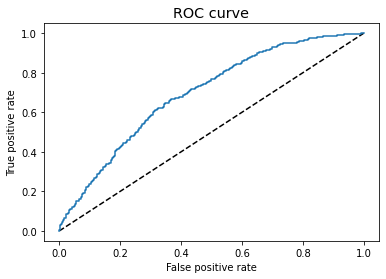

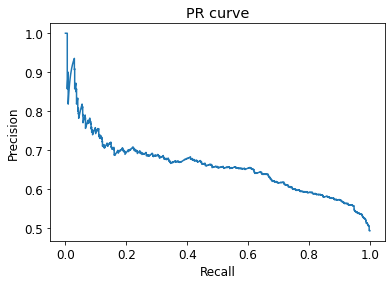

0.694227068505427


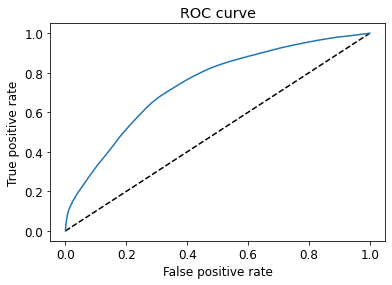

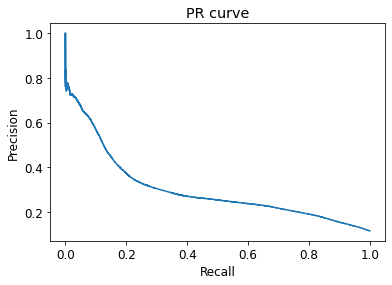

0.7406229657082408


In [49]:
model = torch.load('./phylographnet_job_final50.torch')
model = model.double()
model = model.to(device)

model.eval()

truths = []
preds = []

truths_n = []
preds_n = []

testloader = DataLoader(testingdata , batch_size = 10 )
for i,testdata in enumerate(testloader):
    testdata = testdata.to(device)
    pred = model(testdata.x_dict ,testdata.edge_index_dict)
    pred = {idx:x.to('cpu') for idx,x in pred.items()}
    
    truth = testdata['godnode']['y'][:,0].to('cpu').detach().numpy()
    predy =  pred['godnode'][:,0].to('cpu').detach().numpy()
    truths.append(truth)
    preds.append(predy)
    
    truth_n = testdata['phylonodes_down']['y'][:,0].to('cpu').detach().numpy()
    pred_n =  pred['phylonodes_down'][:,0].to('cpu').detach().numpy()
    
    truths_n.append(truth_n)
    preds_n.append(pred_n)
    
truth = np.hstack(truths)
predy = np.hstack(preds)

print(predy)
print(truth)
ROC_curve_single( truth , predy)
fpr, tpr, _ = roc_curve(  truth  ,predy )
auc_gn = auc(fpr, tpr)
print(auc_gn)
truth_n = np.hstack(truths_n)
predy_n = np.hstack(preds_n)

ROC_curve_single( truth_n, predy_n , 'node_specific')
fpr, tpr, _ = roc_curve(  truth_n  ,predy_n )
auc_n = auc(fpr, tpr)
print(auc_n)

{'Euclidean': {'Ypred': array([-11.78982612, -32.        , -21.51743479, ..., -13.82027496,
       -32.29551052, -19.94993734]), 'Ytrue': array([0, 0, 0, ..., 0, 0, 1])}, 'Hamming': {'Ypred': array([-0.36944128, -0.02394527, -0.09397567, ..., -0.04247434,
       -0.08380844, -0.3995629 ]), 'Ytrue': array([0, 0, 0, ..., 0, 0, 1])}, 'Jaccard': {'Ypred': array([-0.9787234 , -0.85403329, -1.        , ..., -0.57201646,
       -1.        , -0.68455402]), 'Ytrue': array([0, 0, 0, ..., 0, 0, 1])}, 'Pearson': {'Ypred': array([-0.00486374,  0.33810909, -0.00797564, ...,  0.40627641,
       -0.01004298, -0.01534626]), 'Ytrue': array([0, 0, 0, ..., 0, 0, 1])}, 'DNN': {'Ypred': array([[0.9707082 ],
       [0.8823367 ],
       [0.8153586 ],
       ...,
       [0.9694565 ],
       [0.02469606],
       [0.9007809 ]], dtype=float32), 'Ytrue': array([0, 0, 0, ..., 0, 0, 1])}, 'CGN': {'Ypred': array([0.32345492, 0.81900607, 0.89884717, ..., 0.80834349, 0.20017296,
       0.67368718]), 'Ytrue': array([0, 

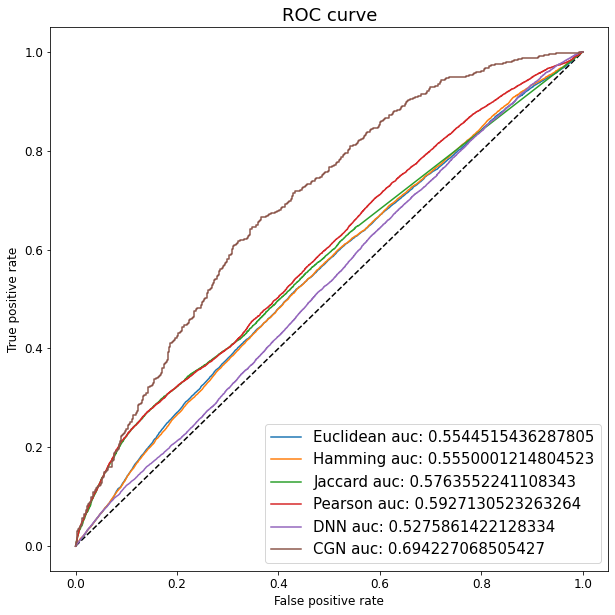

Euclidean
Hamming
Jaccard
Pearson
DNN
CGN


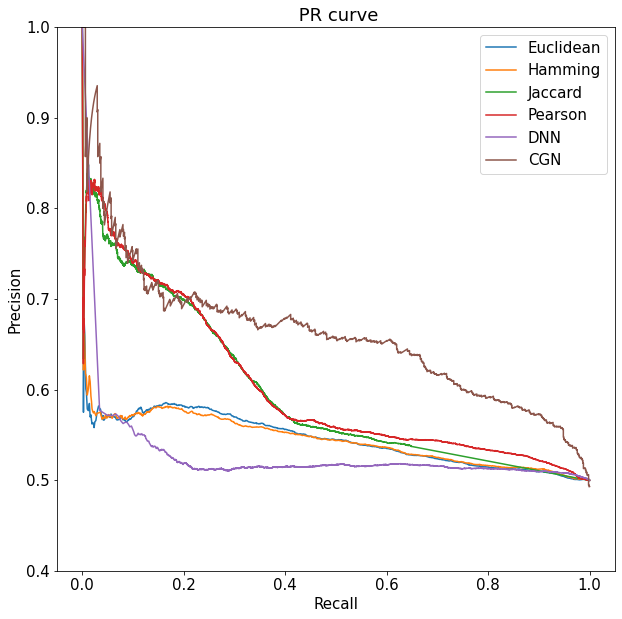

In [50]:
with open('./string_ROCdata.pkl' , 'rb') as ydata_in:
    ydata   = pickle.loads(ydata_in.read())

ydata['CGN'] ={ 'Ypred': predy , 'Ytrue':truth}
#plot ROC
print(ydata)
ROC_curve(ydata , label = 'string')

In [ ]:
####training the CGN on HUMAP data #######

In [63]:
#here we don't infer ancestral states to this function is faster than the one used for string
def create_data_updown_nosectors_humap( tree, coglinkdf, profiles , taxindex , posi_percent = .5 ,  q = None , iolock= None,  verbose = False, loop= True ):
        #upward and downward connected phylo nodes
        connectmat_up, connectmat_down, connectmat_diag, template_features = tree2Single_sparse_graph_updown(tree)
        N = len(tree.nodes())
        allfams = list(set(coglinkdf.fam1.unique()).union( set(coglinkdf.fam2.unique() ) ))
        leafset = set([n.taxon.label for n in tree.leaf_nodes()])
        while True:
            toss = scipy.stats.bernoulli.rvs(posi_percent, loc=0, size=1, random_state=None)
            if verbose == True:
                print('posi/nega',toss)
            if toss == 0:
                fam1 = random.choice(allfams)
                fam2 = fam1
                while fam1 == fam2:
                    fam2 = random.choice(allfams)
                labels = np.zeros((template_features.shape[0],))
            else:
                #positive sample
                dfline = coglinkdf.sample(n=1, random_state = random.randint(1,1000)).iloc[0]
                fam1 = dfline.fam1
                fam2 = dfline.fam2
            nodefeatures = []
            presences= []
            #find profile nameset
            for i,tp in enumerate([profiles[fam1]['tree'], profiles[fam2]['tree']]):    
                profilefeatures = np.zeros((template_features.shape[0],3) )
                #find on which nodes the events happened
                losses = [ taxindex[n.name]  for n in tp.traverse() if n.lost ]
                dupl = [ taxindex[n.name]  for n in tp.traverse() if n.dupl ]
                presence = [ n.name  for n in tp.traverse() if n.nbr_genes > 0   ]
                presences.append(presence)
                presence = [taxindex[n] for n in presence]
                profilefeatures[losses, 0] = 1
                profilefeatures[dupl, 1] = 1
                profilefeatures[presence, 2] = 1
                nodefeatures.append(profilefeatures)
            nodeset = set(presences[0]).union(set(presences[1]))
            if len(nodeset)> 10:
                skip = False
                try:
                    taxset,matrows,n = getmrca(tree,leafset.intersection(nodeset))
                    if taxset == None:
                        skip = True
                except ValueError:
                    #no species overlap
                    skip = True

                if skip == False:
                    
                    #pare down labels

                    overview = scipy.sparse.lil_matrix( (len(matrows) , 2 ) )
                    overview[:,0] = 1

                    overview_rev = sparse2pairs(overview.T)
                    overview = sparse2pairs(overview)

                    #phylonode connections
                    subconnect_up = sparse2pairs(connectmat_up, matrows)
                    subconnect_down = sparse2pairs(connectmat_down, matrows)
                    subdiag = sparse2pairs(connectmat_diag, matrows)
                    
                    
                    #profile features
                    nodefeatures=np.hstack(nodefeatures)
                    
                    sub_template_features= template_features[matrows,:]
                    sub_node_features= nodefeatures[matrows,:]
                    sub_node_features = np.hstack([sub_template_features , sub_node_features])
                    godlabel = np.ones((1,1))*toss
                    godlabel = np.hstack([np.ones((1,1))-godlabel, godlabel])
                    
                    data = HeteroData()    
                    #add input data
                    data['phylonodes_up'].x = torch.tensor(sub_node_features, dtype=torch.double )
                    data['phylonodes_down'].x = torch.tensor(sub_node_features, dtype=torch.double )
                    data['godnode'].x =torch.tensor(  np.zeros((1,1))  ,  dtype=torch.double )

                    #up down fitch net
                    data['phylonodes_up', 'phylolink_up', 'phylonodes_up'].edge_index = torch.tensor(subconnect_up ,  dtype=torch.long )
                    data['phylonodes_down', 'phylolink_down', 'phylonodes_down'].edge_index = torch.tensor(subconnect_down ,  dtype=torch.long )             
                    data['phylonodes_up', 'phylolink_up_down', 'phylonodes_down'].edge_index = torch.tensor( subdiag ,  dtype=torch.long )
                    data['phylonodes_down', 'phylolink_down_up', 'phylonodes_up'].edge_index = torch.tensor( subdiag ,  dtype=torch.long )

                    #pooling connections
                    data['phylonodes_down', 'informs', 'godnode'].edge_index = torch.tensor(overview ,  dtype=torch.long )
                    data['phylonodes_up', 'informs', 'godnode'].edge_index = torch.tensor(overview ,  dtype=torch.long )
                    
                    #pooling connections
                    data['godnode',  'informs','phylonodes_down' ].edge_index = torch.tensor(overview_rev,  dtype=torch.long )
                    data['godnode',  'informs','phylonodes_up'].edge_index = torch.tensor(overview_rev ,  dtype=torch.long )
                    
                    data['godnode'].y =torch.tensor( godlabel  ,  dtype=torch.long )

                    data = T.AddSelfLoops()(data)
                    data = T.NormalizeFeatures()(data)
                    if q:
                        q.put(data)
                    else:
                        yield data

In [64]:
genTrain = create_data_updown_nosectors_humap( dendrotree, Datasets['humap']['Train']  , humap_profiles  ,profile_mapper , .5  , verbose = False  )
print(next(genTrain))

HeteroData(
  phylonodes_up={ x=[3507, 9] },
  phylonodes_down={ x=[3507, 9] },
  godnode={
    x=[1, 1],
    y=[1, 2]
  },
  (phylonodes_up, phylolink_up, phylonodes_up)={ edge_index=[2, 7013] },
  (phylonodes_down, phylolink_down, phylonodes_down)={ edge_index=[2, 7013] },
  (phylonodes_up, phylolink_up_down, phylonodes_down)={ edge_index=[2, 3507] },
  (phylonodes_down, phylolink_down_up, phylonodes_up)={ edge_index=[2, 3507] },
  (phylonodes_down, informs, godnode)={ edge_index=[2, 3507] },
  (phylonodes_up, informs, godnode)={ edge_index=[2, 3507] },
  (godnode, informs, phylonodes_down)={ edge_index=[2, 3507] },
  (godnode, informs, phylonodes_up)={ edge_index=[2, 3507] }
)


In [65]:
#final AUC comparisons
genTest = create_data_updown_nosectors_humap( dendrotree, Datasets['humap']['Test']  , humap_profiles  ,profile_mapper , .5  , verbose = False  )
print(next(genTest))

HeteroData(
  phylonodes_up={ x=[3507, 9] },
  phylonodes_down={ x=[3507, 9] },
  godnode={
    x=[1, 1],
    y=[1, 2]
  },
  (phylonodes_up, phylolink_up, phylonodes_up)={ edge_index=[2, 7013] },
  (phylonodes_down, phylolink_down, phylonodes_down)={ edge_index=[2, 7013] },
  (phylonodes_up, phylolink_up_down, phylonodes_down)={ edge_index=[2, 3507] },
  (phylonodes_down, phylolink_down_up, phylonodes_up)={ edge_index=[2, 3507] },
  (phylonodes_down, informs, godnode)={ edge_index=[2, 3507] },
  (phylonodes_up, informs, godnode)={ edge_index=[2, 3507] },
  (godnode, informs, phylonodes_down)={ edge_index=[2, 3507] },
  (godnode, informs, phylonodes_up)={ edge_index=[2, 3507] }
)


In [ ]:
traindata_gen = True
trainsample= 10000
#create training set using the generator on training samples
reload = True
if traindata_gen == True:
    if reload == True:
        with open('trainingset_nosectors_humap.pkl' , 'rb')as trainout:
            samples = pickle.loads(trainout.read())
        print(len(samples))
    else:
        print('newsamples')
        samples = []
    if traindata_gen == True:
        print('gen samples ' )
        gen = genTrain
        for i , data in enumerate( gen ):
            if i < 5:
                print(data)
                print(data['godnode'].y)
            if i % 100 ==0:
                print(i, len(samples))
                with open('trainingset_nosectors_humap.pkl' , 'wb')as trainout:
                    trainout.write(pickle.dumps(samples))
            samples.append(data)
            if i > trainsample:
                break

In [ ]:
#create testing set using the testing set dataframe
testdata_gen = True
testsample= 5000
NCORE = 20
reload = True

if testdata_gen == True:
    if reload == True:
        with open('testgset_nosectors_humap' , 'rb')as trainout:
            samples = pickle.loads(trainout.read())
    else:
        print('newsamples')
        samples = []
    if testdata_gen == True:
        gen = genTest
        for i , data in enumerate( gen ):
            if i % 100 ==0:
                print(i, len(samples))
                with open('testgset_nosectors_humap' , 'wb')as trainout:
                    trainout.write(pickle.dumps(samples))
            samples.append(data)
            if i > testsample:
                break

In [10]:
with open('trainingset_nosectors_humap.pkl' , 'rb')as trainout:
    trainingdata = pickle.loads(trainout.read())
with open('testgset_nosectors_humap' , 'rb')as trainout:
    testingdata = pickle.loads(trainout.read())
    
data = trainingdata[0]

In [8]:
from torch_geometric.nn import HeteroConv , SAGEConv, Linear , ResGatedGraphConv , GATv2Conv , TransformerConv , MFConv , FiLMConv 

    
import torch_geometric.transforms as T

#without sectornode
class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()
        
        self.convs = torch.nn.ModuleList()
        self.lins =  torch.nn.ModuleList()
        self.lins2 =  torch.nn.ModuleList()
        
        for i in range(num_layers):
            conv = HeteroConv({
                
                ('phylonodes_up', 'phylolink_up', 'phylonodes_up'):MFConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_down', 'phylolink_down', 'phylonodes_down'):MFConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_down', 'phylolink_down_up', 'phylonodes_up'):MFConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_up', 'phylolink_up_down', 'phylonodes_down'):MFConv((-1,-1),  int( hidden_channels) ),
                
                ('phylonodes_down', 'informs', 'godnode'):TransformerConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_up', 'informs', 'godnode'):TransformerConv((-1,-1),  int( hidden_channels) ),
                #('godnode', 'informs', 'phylonodes_down'):SAGEConv((-1,-1),  int( hidden_channels) ),
                #('godnode', 'informs', 'phylonodes_up'):SAGEConv((-1,-1),  int( hidden_channels) ),
            
            } , aggr='sum')
            
            self.convs.append(conv)

            for vectype in  ['phylonodes_up', 'phylonodes_down' , 'sectornode' , 'godnode' ]:
                lin1 = Linear(-1 , int( hidden_channels))
                self.lins.append( lin1 )
                
            print( 'hidden units' , int( hidden_channels) )
            print( 'layer' , i )

        for vectype in ['phylonodes_up', 'phylonodes_down' , 'sectornode' , 'godnode' ]:
            lin2 = Linear(-1 , out_channels)
            self.lins2.append( lin2 ) 

    
    def forward(self, x_dict, edge_index_dict):
        lins = iter(self.lins)
        for i,conv in enumerate(self.convs):
            x_dict = conv(x_dict , edge_index_dict)
            x_dict = {key: F.dropout(x , p = .5 , training = self.training ) for key, x in x_dict.items()}

            for key, x in x_dict.items():
                x_dict[key] = next(lins)(x)
        lins2 = iter(self.lins2)
        
        for key, x in x_dict.items():
            x_dict[key] =  next(lins2)(x)
        
        return {key: F.tanh(x) for key, x in x_dict.items()}
        #return x_dict

model = HeteroGCN(hidden_channels=50 , out_channels=2, num_layers=2)
model = model.double()

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict , data.edge_index_dict)

hidden units 50
layer 0
hidden units 50
layer 1


NameError: name 'data' is not defined

In [25]:
trainloader = DataLoader( trainingdata , batch_size = 50 , shuffle=True)
testloader = DataLoader(testingdata , batch_size = 50 )

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)


In [ ]:
print('start training')
import warnings
#lastauc = 0.7751991361963
lastauc = 0
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = model.to(device)
    for epoch in range(10000):
        model.train()
        truths = []
        preds = []
        truths_n = []
        preds_n = []
        losses3 = []
        for i,data in enumerate(trainloader):
            data = data.to(device)
            out = model(data.x_dict ,data.edge_index_dict)
            optimizer.zero_grad()

            loss3 =  F.smooth_l1_loss(out['godnode'].double(), data['godnode'].y.double())
            loss = loss3
            loss.backward()
            optimizer.step()
            losses3.append(float(loss3.to('cpu')))
            truth = data['godnode']['y'][:,0].to('cpu').detach().numpy()
            predy =  out['godnode'][:,0].to('cpu').detach().numpy()
            truths.append(truth)
            preds.append(predy)


        truth = np.hstack(truths)
        predy = np.hstack(preds)
        fpr, tpr, _ = roc_curve(  truth  ,predy )
        auc_n = auc(fpr, tpr)
        print('losses', np.mean(losses3) )
        print('train auc', auc_n)
        
        model.eval()

        
        truths = []
        preds = []

        truths_n = []
        preds_n = []
        
        
        for i,testdata in enumerate(testloader):
            testdata = testdata.to(device)
            pred = model(testdata.x_dict ,testdata.edge_index_dict)
            truth = testdata['godnode']['y'][:,0].to('cpu').detach().numpy()
            predy =  pred['godnode'][:,0].to('cpu').detach().numpy()
            truths.append(truth)
            preds.append(predy)

        truth = np.hstack(truths)
        predy = np.hstack(preds)
        fpr, tpr, _ = roc_curve(  truth  ,predy )
        auc_gn = auc(fpr, tpr)
        print('test auc',auc_gn)
        if auc_gn > lastauc:
            lastauc = auc_gn
            print('saving')
            torch.save(model, './phylographnet_job_finalhumap.torch')
            print('done')

/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[0.74955669 0.57457402 0.56829278 ... 0.6126809  0.64870238 0.05301656]
[1 1 1 ... 1 1 0]


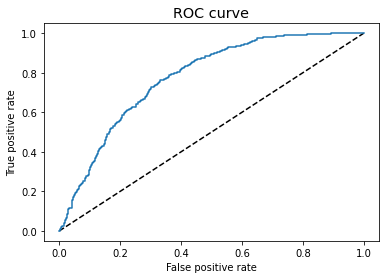

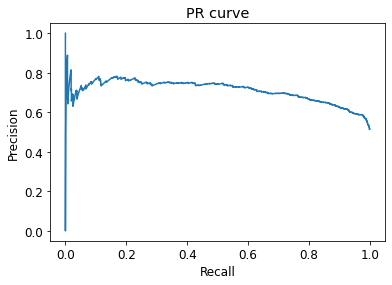

0.7751991361963735


In [11]:
model = torch.load('./phylographnet_job_finalhumap.torch')
model = model.double()
model = model.to(device)

model.eval()

truths = []
preds = []

truths_n = []
preds_n = []

testloader = DataLoader(testingdata , batch_size = 10 )
for i,testdata in enumerate(testloader):
    testdata = testdata.to(device)
    pred = model(testdata.x_dict ,testdata.edge_index_dict)
    pred = {idx:x.to('cpu') for idx,x in pred.items()}
    
    truth = testdata['godnode']['y'][:,0].to('cpu').detach().numpy()
    predy =  pred['godnode'][:,0].to('cpu').detach().numpy()
    truths.append(truth)
    preds.append(predy)

truth = np.hstack(truths)
predy = np.hstack(preds)

print(predy)
print(truth)
ROC_curve_single( truth , predy)

fpr, tpr, _ = roc_curve(  truth  ,predy )
auc_gn = auc(fpr, tpr)
print(auc_gn)


{'Euclidean': {'Ypred': array([-25.88435821, -29.42787794, -34.0881211 , ..., -36.79673899,
       -24.2899156 , -30.28200786]), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}, 'Hamming': {'Ypred': array([-0.12058153, -0.07848727, -0.01938426, ..., -0.0290764 ,
       -0.03658305, -0.06014823]), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}, 'Jaccard': {'Ypred': array([-0.33692142, -0.69714286, -0.69798658, ..., -0.38402778,
       -0.5210084 , -0.56395349]), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}, 'Pearson': {'Ypred': array([0.47730645, 0.57353343, 0.72140037, ..., 0.85214213, 0.82552901,
       0.79159015]), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}, 'DNN': {'Ypred': array([[0.0104006 ],
       [0.09674406],
       [0.5412504 ],
       ...,
       [0.785362  ],
       [0.09448835],
       [0.8712616 ]], dtype=float32), 'Ytrue': array([0, 0, 0, ..., 1, 1, 1])}, 'CGN': {'Ypred': array([0.74955669, 0.57457402, 0.56829278, ..., 0.6126809 , 0.64870238,
       0.05301656]), 'Ytrue': array([1, 1, 1, 

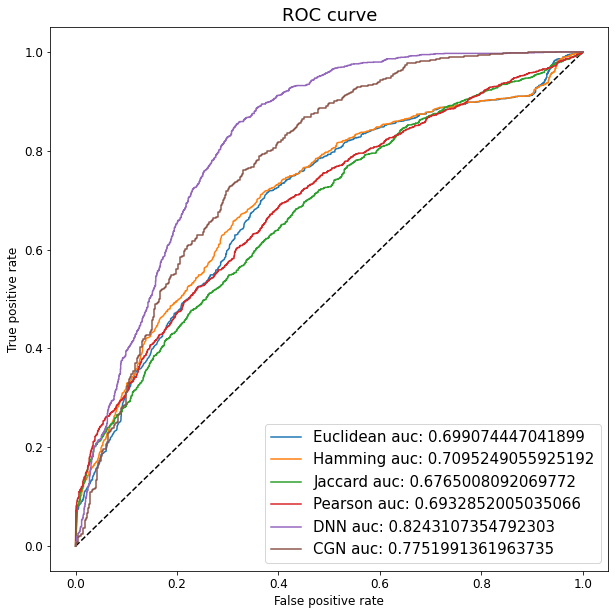

Euclidean
Hamming
Jaccard
Pearson
DNN
CGN


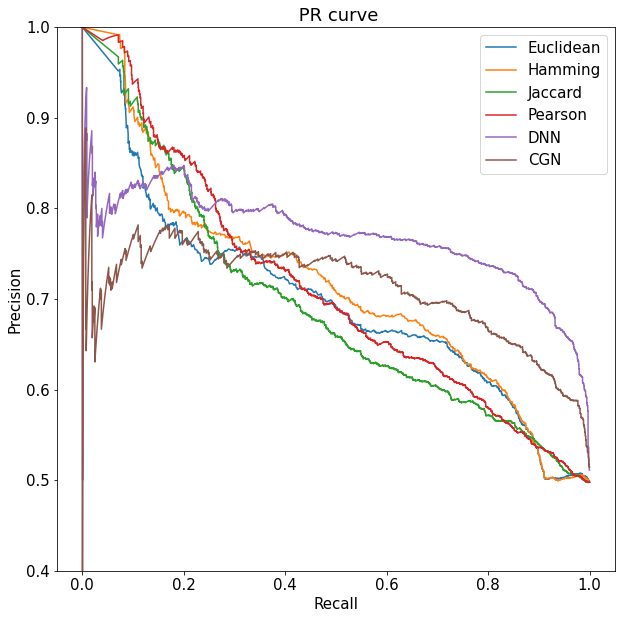

In [12]:
with open('./humap_ROCdata.pkl' , 'rb') as ydata_in:
    ydata   = pickle.loads(ydata_in.read())

ydata['CGN'] ={ 'Ypred': predy , 'Ytrue':truth}
#plot ROC
print(ydata)
ROC_curve(ydata , label = 'humap')